In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

def simulate_langevin_dynamic_lambda(
    dt, num_steps, initial_W, k, temp, 
    lambda_positive_W, lambda_negative_W, 
    threshold=0
):
    """
    Simulates a 1D Langevin equation with dynamically changing lambda
    based on the sign of W.
    
    dW/dt = - lambda(W) * dH/dW + eta(t)
    H(W) = 0.5 * k * W^2
    dH/dW = k * W
    
    lambda(W) = lambda_positive_W if W >= threshold
              = lambda_negative_W if W < threshold
              
    eta(t) is Gaussian white noise with variance 2 * k_B * T * lambda(W) / dt
    Note: We are using a fixed effective 'temperature' for noise power, 
          but the effective damping changes. This is the key to non-Boltzmann.
    
    Args:
        dt (float): Time step.
        num_steps (int): Number of simulation steps.
        initial_W (float): Initial value of W.
        k (float): Spring constant for the harmonic potential.
        temp (float): Temperature in energy units (e.g., k_B * T).
        lambda_positive_W (float): Damping coefficient when W >= threshold.
        lambda_negative_W (float): Damping coefficient when W < threshold.
        threshold (float): The value of W where lambda changes.
        
    Returns:
        numpy.ndarray: Array of W values over time.
        numpy.ndarray: Array of lambda values over time.
    """
    W_values = np.zeros(num_steps)
    lambda_values = np.zeros(num_steps)
    W_values[0] = initial_W
    
    # We will fix the noise strength based on an *average* or *reference* lambda
    # to highlight how the *changing* lambda causes deviation from Boltzmann.
    # If we made the noise strength also dynamic with lambda(W), it could
    # potentially still satisfy a detailed balance-like condition locally,
    # but that's a more complex scenario. Here, we fix the noise variance
    # to a constant, as if the thermal bath is always at temperature T,
    # but the interaction with it (damping) changes based on W.
    
    # Let's fix the noise strength based on an arbitrary 'reference' lambda,
    # say, the average of the two, or just lambda_positive_W.
    # This choice is crucial: it means the "thermal kick" is constant,
    # but the "drag" varies.
    ref_lambda_for_noise = (lambda_positive_W + lambda_negative_W) / 2.0
    
    for i in range(1, num_steps):
        W_prev = W_values[i-1]
        
        # # Determine current lambda based on W_prev
        # if W_prev >= threshold:
        #     current_lambda = lambda_positive_W
        # else:
        #     current_lambda = lambda_negative_W

        if i % 2 == 1:
            current_lambda = lambda_positive_W
        else:
            current_lambda = lambda_negative_W   
            
        lambda_values[i-1] = current_lambda # Store current lambda
        
        # dH/dW
        force_term = -k * W_prev
        
        # Noise term: sqrt(2 * k_B * T * ref_lambda_for_noise * dt) * rand_normal
        # Note: We are using a *fixed* noise strength for the entire simulation
        # This is what breaks Boltzmann if current_lambda != ref_lambda_for_noise
        # If the noise strength also varied as sqrt(2 * k_B * T * current_lambda * dt),
        # then the system *might* maintain local detailed balance in some contexts,
        # but here we fix the thermal noise source as constant for demonstration.
        noise_amplitude = math.sqrt(2 * temp * ref_lambda_for_noise * dt)
        noise_term = noise_amplitude * np.random.normal(0, 1) # Standard normal
        
        # Update W
        dW = (current_lambda * force_term) * dt + noise_term
        W_values[i] = W_prev + dW
        
    lambda_values[num_steps-1] = current_lambda # Store last lambda
        
    return W_values, lambda_values

# --- Simulation Parameters ---
dt = 0.01          # Time step
num_steps = 1_000_000 # Number of simulation steps (long to reach steady state)
initial_W = 0.0    # Start at the potential minimum
k = 1.0            # Spring constant
temp = 1.0         # "Temperature" (k_B * T)
threshold = 0.0    # Threshold for lambda change

# --- Scenario 1: Equilibrium (for comparison) ---
# Both lambdas are the same, should recover Boltzmann (Gaussian)
lambda_eq = 0.5
W_eq, _ = simulate_langevin_dynamic_lambda(
    dt, num_steps, initial_W, k, temp, 
    lambda_eq, lambda_eq, threshold
)

# --- Scenario 2: Non-Equilibrium with Dynamic Lambda ---
# Different lambdas create asymmetry, breaking Boltzmann
lambda_positive_W_ne = 0.1 # Low damping when W > 0 (makes it easy to move away)
lambda_negative_W_ne = 1.0 # High damping when W < 0 (makes it harder to move back)

W_ne, lambda_vals_ne = simulate_langevin_dynamic_lambda(
    dt, num_steps, initial_W, k, temp, 
    lambda_positive_W_ne, lambda_negative_W_ne, threshold
)

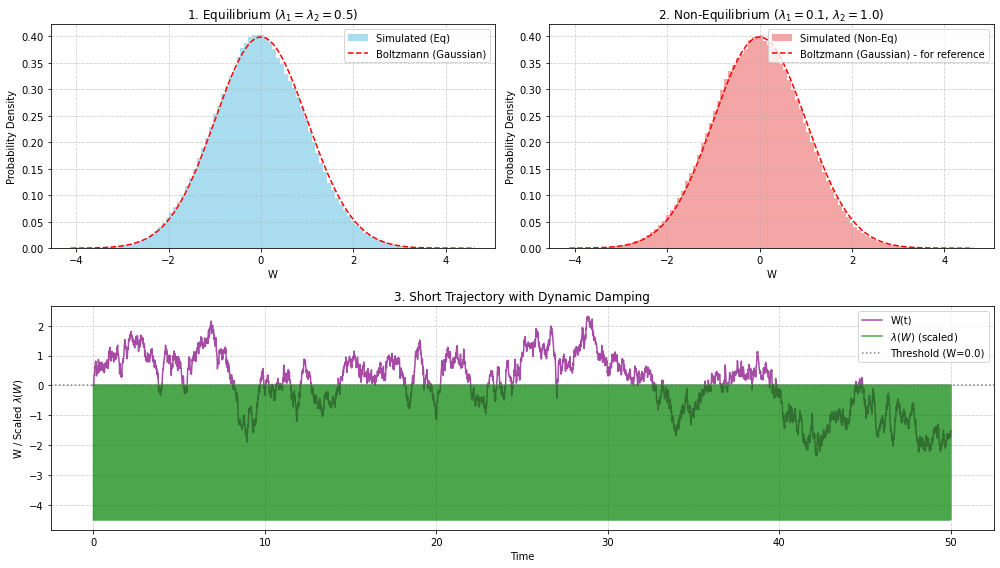

Mean of W for Equilibrium case: -0.0307
Variance of W for Equilibrium case: 1.0029
Expected Boltzmann Variance (T/k): 1.0000
------------------------------
Mean of W for Non-Equilibrium case: -0.0412
Variance of W for Non-Equilibrium case: 0.9980


In [18]:
# --- Analysis and Plotting ---

# Expected Boltzmann distribution for a harmonic potential
# P(W) = A * exp(-H(W) / T) = A * exp(-0.5 * k * W^2 / T)
# For a Gaussian, mean = 0, variance = T / k
# Std dev = sqrt(T/k)
sigma_boltzmann = np.sqrt(temp / k)

plt.figure(figsize=(14, 8))

# Subplot 1: Probability Distribution for Equilibrium Case
plt.subplot(2, 2, 1)
plt.hist(W_eq[int(num_steps*0.1):], bins=100, density=True, alpha=0.7, color='skyblue', label='Simulated (Eq)')
x_boltzmann = np.linspace(W_eq.min(), W_eq.max(), 500)
pdf_boltzmann = (1 / (sigma_boltzmann * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (x_boltzmann / sigma_boltzmann)**2)
plt.plot(x_boltzmann, pdf_boltzmann, 'r--', label='Boltzmann (Gaussian)')
plt.title(f'1. Equilibrium ($\\lambda_1 = \\lambda_2 = {lambda_eq}$)')
plt.xlabel('W')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Subplot 2: Probability Distribution for Non-Equilibrium Case
plt.subplot(2, 2, 2)
plt.hist(W_ne[int(num_steps*0.1):], bins=100, density=True, alpha=0.7, color='lightcoral', label='Simulated (Non-Eq)')
plt.plot(x_boltzmann, pdf_boltzmann, 'r--', label='Boltzmann (Gaussian) - for reference')
plt.title(f'2. Non-Equilibrium ($\\lambda_1={lambda_positive_W_ne}$, $\\lambda_2={lambda_negative_W_ne}$)')
plt.xlabel('W')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Subplot 3: Trajectory of W for Non-Equilibrium Case
plt.subplot(2, 1, 2)
time_points = np.arange(0, num_steps * dt, dt)
plt.plot(time_points[:5000], W_ne[:5000], label='W(t)', color='purple', alpha=0.7)
plt.plot(time_points[:5000], lambda_vals_ne[:5000]*5 - 5, label='$\\lambda(W)$ (scaled)', color='green', alpha=0.7) # Scaled for visibility
plt.axhline(y=threshold, color='gray', linestyle=':', label=f'Threshold (W={threshold})')
plt.title('3. Short Trajectory with Dynamic Damping')
plt.xlabel('Time')
plt.ylabel('W / Scaled $\\lambda(W)$')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(f"Mean of W for Equilibrium case: {np.mean(W_eq[int(num_steps*0.1):]):.4f}")
print(f"Variance of W for Equilibrium case: {np.var(W_eq[int(num_steps*0.1):]):.4f}")
print(f"Expected Boltzmann Variance (T/k): {temp/k:.4f}")
print("-" * 30)
print(f"Mean of W for Non-Equilibrium case: {np.mean(W_ne[int(num_steps*0.1):]):.4f}")
print(f"Variance of W for Non-Equilibrium case: {np.var(W_ne[int(num_steps*0.1):]):.4f}")
# The distribution will be skewed, so variance might not directly compare
# to T/k, but the shift from 0 mean is a clear indicator of non-Boltzmann.

In [19]:
print(np.mean(W_eq))
print(np.std(W_eq))

-0.02592075056030692
1.0075199075515051
